In [1]:
%matplotlib inline

http://alleninstitute.github.io/AllenSDK/_static/examples/nb/mouse_connectivity.html

In [16]:
import pandas as pd
import numpy as np
import nibabel as nb
from nighres.io import io_mesh
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from nipype.interfaces import fsl

In [3]:
data_dir = '/home/julia/data/gradients/allen_atlas/'

### Download template and save to nifti

In [4]:
mcc = MouseConnectivityCache(manifest_file=data_dir+'allen_manifest.json')

In [5]:
template, template_info = mcc.get_template_volume('/tmp/template.nrrd')
nb.Nifti1Image(template, np.eye(4)*0.025).to_filename(data_dir+'template.nii.gz')

2020-06-11 13:19:00,526 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/average_template/average_template_25.nrrd


### Access information from structure tree

In [6]:
structure_tree = mcc.get_structure_tree()
structure_tree.get_name_map()

{997: 'root',
 8: 'Basic cell groups and regions',
 567: 'Cerebrum',
 688: 'Cerebral cortex',
 695: 'Cortical plate',
 315: 'Isocortex',
 184: 'Frontal pole, cerebral cortex',
 68: 'Frontal pole, layer 1',
 667: 'Frontal pole, layer 2/3',
 526157192: 'Frontal pole, layer 5',
 526157196: 'Frontal pole, layer 6a',
 526322264: 'Frontal pole, layer 6b',
 500: 'Somatomotor areas',
 107: 'Somatomotor areas, Layer 1',
 219: 'Somatomotor areas, Layer 2/3',
 299: 'Somatomotor areas, Layer 5',
 644: 'Somatomotor areas, Layer 6a',
 947: 'Somatomotor areas, Layer 6b',
 985: 'Primary motor area',
 320: 'Primary motor area, Layer 1',
 943: 'Primary motor area, Layer 2/3',
 648: 'Primary motor area, Layer 5',
 844: 'Primary motor area, Layer 6a',
 882: 'Primary motor area, Layer 6b',
 993: 'Secondary motor area',
 656: 'Secondary motor area, layer 1',
 962: 'Secondary motor area, layer 2/3',
 767: 'Secondary motor area, layer 5',
 1021: 'Secondary motor area, layer 6a',
 1085: 'Secondary motor area, 

### Download and save masks and meshes for brain, piriform cortex and hippocampus

In [7]:
structures = structure_tree.get_structures_by_name(['root', 'Hippocampal region', 'Piriform area'])
pd.DataFrame(structures)

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,root,1,0,997,root,[997],[691663206],"[255, 255, 255]"
1,HIP,1,455,1080,Hippocampal region,"[997, 8, 567, 688, 695, 1089, 1080]","[112905828, 691663206, 12, 184527634, 11290581...","[126, 208, 75]"
2,PIR,1,416,961,Piriform area,"[997, 8, 567, 688, 695, 698, 961]","[112905828, 691663206, 688152358, 687527945, 1...","[106, 203, 186]"


In [8]:
root_mask, root_info = mcc.get_structure_mask(997, '/tmp/brain.nrrd')
nb.Nifti1Image(root_mask, np.eye(4)*0.025).to_filename(data_dir+'brain.nii.gz')

In [9]:
root_mesh=mcc.get_structure_mesh(997, '/tmp/brain_mesh.obj')
io_mesh.save_mesh_geometry(data_dir+'brain_mesh.vtk',
                           {"points":root_mesh[0], "faces":root_mesh[2]})


Saving /home/julia/data/gradients/allen_atlas/brain_mesh.vtk


In [10]:
hpc_mask, hpc_info = mcc.get_structure_mask(1080, '/tmp/hpc.nrrd')
nb.Nifti1Image(hpc_mask, np.eye(4)*0.025).to_filename(data_dir+'hippocampus.nii.gz')

In [11]:
piri_mask, piri_info = mcc.get_structure_mask(961, '/tmp/piri.nrrd')
nb.Nifti1Image(piri_mask, np.eye(4)*0.025).to_filename(data_dir+'piriform.nii.gz')

### Make masks for individual layers of isocortex

In [11]:
iso_structs = structure_tree.descendants([315])[0]

In [12]:
l1 = []
l2_3 = []
l4 = []
l5 = []
l6a = []
l6b = []
lx = []

for i in range(len(iso_structs)):
    if 'layer 1' in iso_structs[i]['name'].lower():
        l1.append(iso_structs[i])
    elif 'layer 2/3' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 2' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 4' in iso_structs[i]['name'].lower():
        l4.append(iso_structs[i])
    elif 'layer 5' in iso_structs[i]['name'].lower():
        l5.append(iso_structs[i])
    elif 'layer 6a' in iso_structs[i]['name'].lower():
        l6a.append(iso_structs[i])
    elif 'layer 6b' in iso_structs[i]['name'].lower():
        l6b.append(iso_structs[i])
    else:
        lx.append(iso_structs[i])            

In [13]:
layers = ['l1', 'l2_3', 'l4', 'l5', 'l6a', 'l6b']
layer_lists = [l1, l2_3, l4, l5, l6a, l6b]
layer_plot = np.zeros_like(template)

for l in range(len(layers)):
    layer_mask = np.zeros_like(template)
    for m in layer_lists[l]:
        try:
            mask, _ = mcc.get_structure_mask(m['id'], '/tmp/%s.nrrd' %m['id'])
            layer_mask += mask
        except:
            pass
    layer_plot[layer_mask==1] = (l+1)*10
    nb.Nifti1Image(layer_mask, np.eye(4)*0.025).to_filename(data_dir+'layers/%s.nii.gz' %layers[l])

2020-06-08 15:32:55,629 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_68.nrrd
2020-06-08 15:32:57,608 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_107.nrrd
2020-06-08 15:32:58,150 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/107.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_107.nrrd (request).
2020-06-08 15:32:58,153 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally usin

2020-06-08 15:33:26,281 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_801.nrrd
2020-06-08 15:33:26,829 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/801.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_801.nrrd (request).
2020-06-08 15:33:26,832 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:33:26,835 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release

2020-06-08 15:34:00,023 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149290.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149290.nrrd (request).
2020-06-08 15:34:00,026 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:34:00,029 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149318.nrrd
2020-06-08 15:34:00,535 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149318.nrrd from http://download.allen

2020-06-08 15:34:22,726 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:34:22,729 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_113.nrrd
2020-06-08 15:34:24,338 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_657.nrrd
2020-06-08 15:34:25,734 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/struc

2020-06-08 15:34:58,879 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_195.nrrd
2020-06-08 15:34:59,389 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/195.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_195.nrrd (request).
2020-06-08 15:34:59,392 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:34:59,394 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release

2020-06-08 15:35:18,379 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_606.nrrd
2020-06-08 15:35:18,872 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/606.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_606.nrrd (request).
2020-06-08 15:35:18,875 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:35:18,878 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release

2020-06-08 15:35:48,204 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149242.nrrd
2020-06-08 15:35:48,747 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149242.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149242.nrrd (request).
2020-06-08 15:35:48,750 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:35:48,753 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archi

2020-06-08 15:36:11,141 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_312782612.nrrd
2020-06-08 15:36:12,780 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_234.nrrd
2020-06-08 15:36:15,419 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_526157192.nrrd
2020-06-08 15:36:16,979 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_299.nrrd
2020

2020-06-08 15:36:40,288 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_847.nrrd
2020-06-08 15:36:41,556 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_791.nrrd
2020-06-08 15:36:43,226 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1023.nrrd
2020-06-08 15:36:44,628 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_937.nrrd
2020-06-08 15:3

2020-06-08 15:37:15,577 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149274.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149274.nrrd (request).
2020-06-08 15:37:15,580 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:37:15,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149302.nrrd
2020-06-08 15:37:16,098 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149302.nrrd from http://download.allen

2020-06-08 15:37:36,357 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1038.nrrd
2020-06-08 15:37:39,514 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149222.nrrd
2020-06-08 15:37:40,056 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149222.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149222.nrrd (request).
2020-06-08 15:37:40,059 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build t

2020-06-08 15:38:12,854 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:38:12,858 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_919.nrrd
2020-06-08 15:38:14,330 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_84.nrrd
2020-06-08 15:38:15,939 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/struct

2020-06-08 15:38:38,394 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_335.nrrd
2020-06-08 15:38:39,861 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_977.nrrd
2020-06-08 15:38:42,437 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_526322264.nrrd
2020-06-08 15:38:43,686 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_947.nrrd
2020-06-08

2020-06-08 15:39:07,784 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_456.nrrd
2020-06-08 15:39:09,427 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_598.nrrd
2020-06-08 15:39:10,967 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_497.nrrd
2020-06-08 15:39:11,500 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/497.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_

2020-06-08 15:39:40,515 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149310.nrrd
2020-06-08 15:39:41,020 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /tmp/480149310.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149310.nrrd (request).
2020-06-08 15:39:41,022 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-06-08 15:39:41,025 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archi

### Fix hole in layer 6 and save layers and mask

Mask was created manually by filling in the whole in FSLeyes

In [14]:
missing_piece = nb.load(data_dir+'layers/missing_piece_cortex.nii.gz').get_data()

l6a = nb.load(data_dir+'layers/l6a.nii.gz')
nb.save(l6a,data_dir+'layers/l6a_orig.nii.gz')

l6a_fixed = np.zeros_like(l6a.get_data())
l6a_fixed[l6a.get_data()==1]=1
l6a_fixed[missing_piece==1]=1
nb.save(nb.Nifti1Image(l6a_fixed, l6a.affine),data_dir+'layers/l6a.nii.gz')

In [16]:
layers = ['l1', 'l2_3', 'l4', 'l5', 'l6a', 'l6b']
layer_plot = np.zeros_like(template)

for l in range(len(layers)):
    layer = nb.load(data_dir+'layers/%s.nii.gz' %layers[l]).get_data()
    layer_plot[layer==1] = (l+1)
nb.save(nb.Nifti1Image(layer_plot, np.eye(4)*0.025), data_dir+'layers/all_layers.nii.gz')

In [19]:
cortex = np.zeros_like(layer_plot)
cortex[layer_plot!=0]=1
aff=np.eye(4)*0.025
aff[3,3]=1
nb.save(nb.Nifti1Image(cortex, aff), data_dir+'cortex_mask_tight.nii.gz')

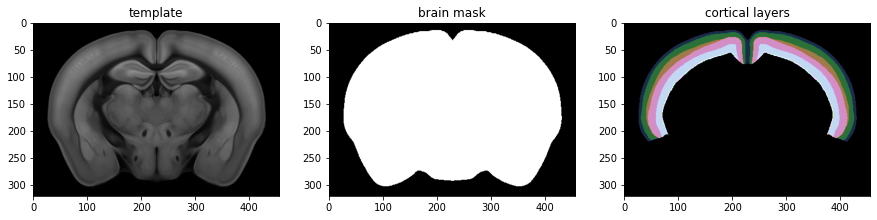

In [28]:
slice_idx = 264
f, ccf_axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_axes[0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0].set_title("template")
ccf_axes[1].imshow(root_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[1].set_title("brain mask")
ccf_axes[2].imshow(layer_plot[slice_idx,:,:], cmap='cubehelix', aspect='equal')
ccf_axes[2].set_title("cortical layers")
plt.show()

### Make custom annotation volume from substructures of isocortex

In [12]:
iso_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']
regions = structure_tree.children([iso_id])[0]

In [13]:
hdr = nb.load(data_dir+'cortex_mask_tight.nii.gz').header
aff = nb.load(data_dir+'cortex_mask_tight.nii.gz').affine
shape = nb.load(data_dir+'cortex_mask_tight.nii.gz').shape

In [ ]:
for region in regions:
    children = structure_tree.children([region['id']])[0]
    for child in children:
        if "layer" in child['name'].lower():
            pass
        elif child['id'] == 738: #structure is missing in API
            pass
        else:
            mask, _ = mcc.get_structure_mask(child['id'],'/tmp/%s.nrrd' % child['acronym'])
            nb.Nifti1Image(mask, aff, hdr).to_filename(data_dir+'regions/%s.nii.gz'% child['acronym'])

In [ ]:
# Start a list of subregions
finest = []
for region in regions:
    children = structure_tree.children([region['id']])[0]
    for child in children:
        if "layer" in child['name'].lower():
            pass
        elif child['id'] == 738:
            pass
        else:
            finest.append(child['acronym'])

In [ ]:
# Add the level 1 regions that have no subregions
for region in regions:
    if True in [(region['acronym'] in f) for f in finest]:
        pass
    else:
        finest.append(region['acronym'])
        mask, _ = mcc.get_structure_mask(region['id'],'/tmp/%s.nrrd' % region['acronym'])
        nb.Nifti1Image(mask, aff, hdr).to_filename(data_dir+'regions/%s.nii.gz'% region['acronym'])

In [ ]:
# Add subregions of SSp
for ss in structure_tree.children([322])[0]:
    if "layer" in ss['name'].lower():
        pass
    else:
        finest.append(ss['acronym'])
        mask, _ = mcc.get_structure_mask(ss['id'], '/tmp/%s.nrrd' % ss['acronym'])
        nb.Nifti1Image(mask, aff, hdr).to_filename(data_dir+'regions/%s.nii.gz' % ss['acronym'])
finest.remove('SSp')

In [ ]:
df = pd.DataFrame(data=zip(range(1,len(finest)+1),finest),
                 columns=['id', 'acronym'])
df.to_csv('/home/julia/workspace/mouse_gradients/regions.csv')

In [ ]:
# Make a single annotation volume
annot_finest = np.zeros(shape)

for a in range(len(df['acronym'])):
    mask = nb.load(data_dir+'regions/%s.nii.gz' % df['acronym'][a]).get_data()
    annot_finest[mask == 1] = df['id'][a]

nb.save(nb.Nifti1Image(np.round(annot_finest), aff, hdr), data_dir+'annot_finest.nii.gz')

### Downsample volumes to 200um to fit resolution of fMRI data

In [ ]:
# Annotation volume
resamp = fsl.FLIRT(in_file=data_dir+'annot_finest.nii.gz',
                   reference=data_dir+'annot_finest.nii.gz',
                   apply_isoxfm=0.2,
                   interp='nearestneighbour',
                   out_file=data_dir+'annot_finest_200um.nii.gz')
resamp.run()

In [ ]:
# Round it back to integers
rounded = np.round(nb.load(data_dir+'annot_finest_200um.nii.gz').get_data())
hdr_200 = nb.load(data_dir+'annot_finest_200um.nii.gz').header
aff_200 = nb.load(data_dir+'annot_finest_200um.nii.gz').affine
nb.save(nb.Nifti1Image(rounded, aff_200, hdr_200), data_dir+'annot_finest_200um.nii.gz')

In [ ]:
# Template
resamp = fsl.FLIRT(in_file=data_dir+'template.nii.gz',
                   reference=data_dir+'template.nii.gz',
                   apply_isoxfm=0.2,
                   interp='spline',
                   out_file=data_dir+'template_200um.nii.gz')
resamp.run()

In [18]:
# Cortex, Piriform and Hippocampus mask
for m in ['cortex_mask_tight', 'piriform', 'hippocampus']:
    resamp = fsl.FLIRT(in_file=data_dir+'%s.nii.gz' % m,
                       reference=data_dir+'%s.nii.gz' % m,
                       apply_isoxfm=0.2,
                       interp='nearestneighbour',
                       out_file=data_dir+'%s_200um.nii.gz' % m)
    resamp.run()